# Recitation 1: More about MIMIC

MIMIC-III is the largest publically available clinical dataset.

Here we seek to do two exploratory tasks:

1) Plot age distribution at admissions.

2) Plot heart rates. Then heart rates by age.

In [1]:
import datetime
import numpy as np

import pandas as pd
import psycopg2


%matplotlib inline
from matplotlib import pyplot as plt

def clean_plot():
    ax = plt.subplot(111) 
    ax.spines["top"].set_visible(False) 
    ax.spines["bottom"].set_visible(False) 
    ax.spines["right"].set_visible(False) 
    ax.spines["left"].set_visible(False) 
    ax.grid()
    ax.get_xaxis().tick_bottom() 
    ax.get_yaxis().tick_left() 

/afs/csail.mit.edu/u/i/iychen/.local/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Let's set up our connection to our MIMIC postgres server. For more information on installing MIMIC, see the [official documentation](https://mimic.physionet.org/gettingstarted/dbsetup/).



In [2]:
sqluser = 'iychen' # change this to whatever your username is
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

query = \
"""
select 
   subject_id, dob
from patients
"""

patients_df = pd.read_sql_query(query,con)
print len(patients_df)

query = \
"""
select
   subject_id, admittime, insurance
from admissions
"""

admissions_df = pd.read_sql_query(query, con)
print len(admissions_df)

46520
58976


Since the patients table has the date of birth and the admissions table has the date of admission, we need to merge the two tables using the field `subject_id`, which is shared across both tables.

In [3]:
df = admissions_df.merge(patients_df, on='subject_id', how='left')

Working with dates and times is tricky in Python, so we write a function to compute the age. Note that subtracting two datetimes will give us the distance in seconds, and we divide appropriately. 

In [4]:
def get_age(dob, admittime):
    diff = (admittime - dob).total_seconds() / (3600 * 24 * 365.25)
    return diff

In [5]:
df['age'] = df.apply(lambda x: get_age(x['dob'], x['admittime']), axis=1)

We are finally ready to plot the distribution of ages for our dataset! As expected, we have two spikes around 0 and 300 due to the neonatal ICU and the HIPAA-compliant obscuring of ages for people over 90. 

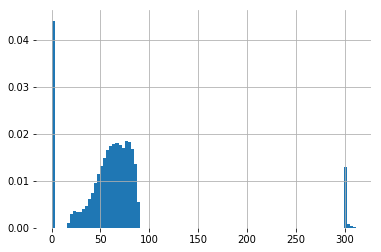

In [6]:
plt.hist(df['age'], bins=100, normed=True)
clean_plot()
plt.show()

Next we want to plot the distribution of heart rates in our dataset. We see that the information we want is from `chartevents`. 

In [8]:
query = \
"""
select * from chartevents 
where itemid in (211, 220045) and valuenum is not null
"""

hrt_df = pd.read_sql_query(query,con)
print len(hrt_df)

7941588


Recall that MIMIC-III covers the time period when Beth Israel Deaconness Medical Center transitioned from one medical system to another. These two systems are called Carevue and Metavision.

We see that Carevue has a bimodal heart rate distribution.

In [10]:
hrt_df['system'] = hrt_df['itemid'].apply(lambda x: 'Carevue' if x == 211 else 'Metavision')

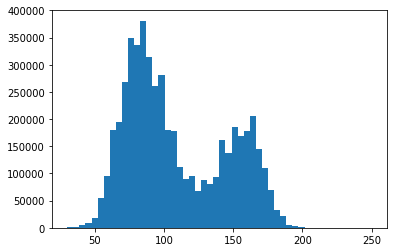

In [11]:
c_values = hrt_df[hrt_df['system'] == 'Carevue']['value'].astype(float)
c_values = [i for i in c_values if not np.isnan(i)]
c_values = [i for i in c_values if i <= 250 and i >= 30]
plt.hist(c_values,bins=50)
plt.show()

As noted in Lecture 3, Metavision has a single modal heart rate distribution. Why?

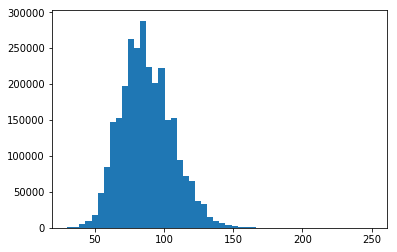

In [12]:
m_values = hrt_df[hrt_df['system'] == 'Metavision']['value'].astype(float)
m_values = [i for i in m_values if not np.isnan(i)]
m_values = [i for i in m_values if i <= 250 and i >= 30]
plt.hist(m_values, bins=50)
plt.show()

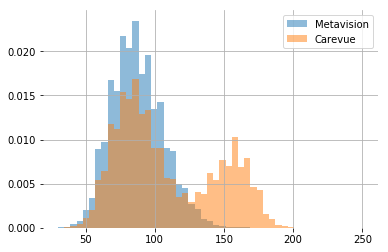

In [13]:
plt.hist(m_values, normed=True, bins=np.linspace(30,250,50),alpha=0.5, label='Metavision')
plt.hist(c_values, normed=True, bins=np.linspace(30,250,50),alpha=0.5, label='Carevue')
plt.legend()
clean_plot()
plt.show()

What about heart rates by ages? First we want to merge back onto our patient table.

In [14]:
df2 = hrt_df.merge(patients_df, on='subject_id', how='left')

In [15]:
print len(df2)

7941588


Because the heart rate table has over 7 million rows, it takes awhile to get anything done. Let's only use the first occurrence of each patient and use the heart rate there.

In [25]:
df3 = df2.groupby('subject_id', as_index=False).first()
print len(df3)

45988


Next we want to remove any outliers in age and in heart rate. Also we notice that heart rate is a string, so we convert to float.

In [34]:
df3['age'] = df3.apply(lambda x: get_age(x['dob'], x['charttime']), axis=1)

df3['value'] = df3['value'].astype(float)

In [35]:
print np.max(df3['age']), np.min(df3['age'])
print np.max(df3['value']), np.min(df3['value'])

310.2785763175907 0.0
204.0 30.0


In [37]:
df3 = df3[(df3['age'] >= 0) & (df3['age'] < 400)]
df3 = df3[(df3['value'] >= 30) & (df3['value'] <= 250)]

In [38]:
print len(df3)

45795


Now we can finally plot our heart rate distribution by age! As expected, this explains the bimodal distribution from Carevue because it now includes neonatal patients as well.

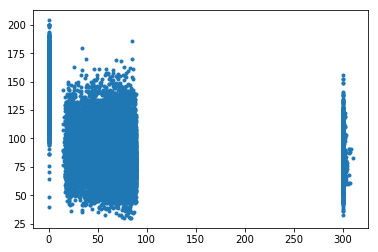

In [39]:
plt.plot(df3['age'], df3['value'], '.')

# Logistic Regression

We want to demonstrate how to run a logistic regression on a toy problem: predicting death from other admissions quantities.

Note that we don't differentiate out types of death (in hopsital, in-ICU) and we are only using admissions numbers.

In [44]:
query = \
"""
select 
   *
from patients
"""

patients_df = pd.read_sql_query(query,con)
print len(patients_df)

46520


In [ ]:
admissions_df

In [49]:
query = \
"""
select
   *
from admissions
"""

admissions_df = pd.read_sql_query(query, con)
print len(admissions_df)

58976


For our output label, we choose `hospital_expire_flag`, which is 1 if a patient dies or 0 if not.

In [54]:
admissions_df['hospital_expire_flag'].mean()

0.09926071622354857

Although we could use many more features (and we do in HW1), we choose four simple features to include in this model.

Note that because all of our features are categorical, we need to binarize our data using `get_dummies` which transforms a categorical feature of `x = ['a', 'b', 'a']` to `x = [[1, 0], [0,1], [1,0]]` where the columns are `a, b`. 

In [98]:
X1 = pd.get_dummies(admissions_df['admission_type'], prefix='adm')
X2 = pd.get_dummies(admissions_df['admission_location'],prefix='loc')
X3 = pd.get_dummies(admissions_df['insurance'], prefix='insur')
X4 = pd.get_dummies(admissions_df['marital_status'], prefix='marital')

In [99]:
X = pd.concat([X1, X2, X3, X4], axis=1)
y = admissions_df['hospital_expire_flag']

In [100]:
print X.shape
print y.shape

(58976, 25)
(58976,)


Lastly we train a logistic regression using standard ML techniques like splitting into train and test sets. We are mostly interested in the AUC, so we compute the predicted probability and compare to the true label.

In [102]:
clf = LogisticRegression()

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7)

In [104]:
clf.fit(X_train,y_train)
print clf.score(X_test,y_test)

0.90069519018821


In [105]:
y_probs = clf.predict_proba(X_test)[:,1]

In [106]:
print roc_auc_score(y_test, y_probs)

0.6966738789249199


How does each feature contribute to a person's likelihood of dying in the hospital? We can examine the LR coefficients for that.

In [108]:
for i,j in sorted(zip(X.columns,clf.coef_[0]), key=lambda x: x[1]):
    print i,j

adm_NEWBORN -2.362588072315625
marital_SINGLE -1.1263287531918926
marital_LIFE PARTNER -1.0335357846593487
marital_DIVORCED -0.883965570562124
marital_MARRIED -0.7965596873557327
marital_SEPARATED -0.7601818007072149
insur_Government -0.73249373071663
marital_WIDOWED -0.6846488546143337
loc_PHYS REFERRAL/NORMAL DELI -0.6366554885217509
adm_ELECTIVE -0.5719963557598011
loc_CLINIC REFERRAL/PREMATURE -0.5153404673007015
insur_Medicaid -0.46347966621285563
insur_Private -0.4594082219285568
loc_TRSF WITHIN THIS FACILITY -0.4132519712387847
marital_UNKNOWN (DEFAULT) -0.34160504626592353
loc_EMERGENCY ROOM ADMIT -0.33443265315165105
loc_TRANSFER FROM HOSP/EXTRAM -0.3264593259041748
loc_TRANSFER FROM OTHER HEALT -0.107928938471283
loc_TRANSFER FROM SKILLED NUR 0.07117429834907459
insur_Medicare 0.073442779364
insur_Self Pay 0.14290015020296432
loc_** INFO NOT AVAILABLE ** 0.14414603595626907
adm_URGENT 0.6518055888445157
loc_HMO REFERRAL/SICK 0.6797098210849573
adm_EMERGENCY 0.8437401497812353